# Arrow Reapplication Notebook



In [1]:
!nvidia-smi

Thu Feb  5 23:42:22 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.105.08             Driver Version: 580.105.08     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L40S                    Off |   00000000:83:00.0 Off |                    0 |
| N/A   26C    P8             32W /  350W |       0MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
os.environ['HF_HOME'] = '/gscratch/scrubbed/xckevin/hf_cache'
os.environ['TMPDIR'] = '/gscratch/scrubbed/xckevin/tmp'

In [3]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2
import random
from ultralytics import YOLO
from transformers import Sam3Processor, Sam3Model
from huggingface_hub import login, hf_hub_download

# Check available GPUs
print("Available GPUs:")
for i in range(torch.cuda.device_count()):
    print(f"  GPU {i}: {torch.cuda.get_device_name(i)}")
print(f"Total GPUs: {torch.cuda.device_count()}\n")

# Authenticate with Hugging Face
login()

Available GPUs:
  GPU 0: NVIDIA L40S
  GPU 1: NVIDIA L40S
Total GPUs: 2



### Detect Arrows, Tips, and Tails Prior to Segmentation

In [5]:
model_path = 'arrow-detector-medium-combined-v2.pt'

# Load the trained model
loaded_model = YOLO(model_path)

# Set YOLO to use GPU (automatically uses first available GPU)
# For multi-GPU inference, set device to list of GPUs or let it auto-distribute
if torch.cuda.is_available():
    loaded_model.to('cuda')
    print(f"Model loaded on CUDA device")
else:
    print(f"No CUDA available, using CPU")

print(f"Model loaded successfully from: {model_path}")

Model loaded on CUDA device
Model loaded successfully from: arrow-detector-medium-combined-v2.pt



image 1/1 /gscratch/krishna/xckevin/arrow-detection/pics/pic5.jpeg: 640x512 3 arrows, 5.6ms
Speed: 1.2ms preprocess, 5.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


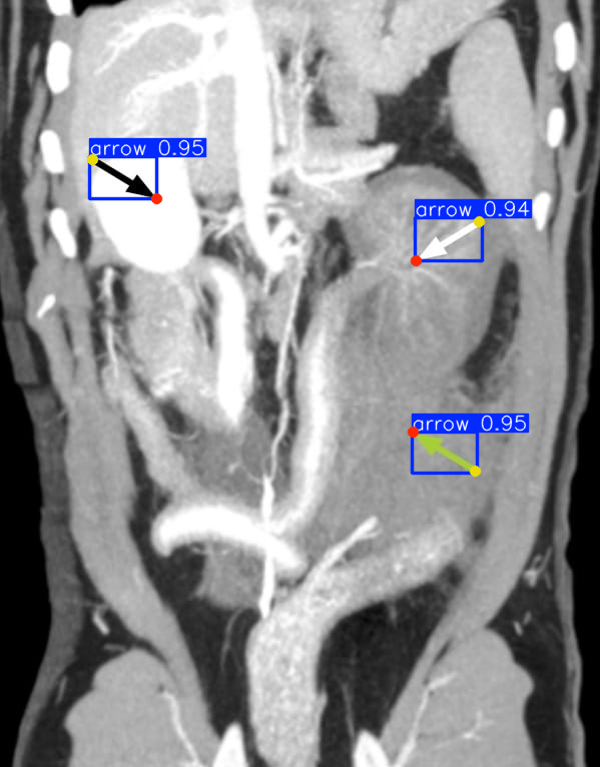

Bounding Boxes:
Arrow 1:  [[411.77093505859375, 431.49298095703125, 476.4808044433594, 472.92877197265625]]
Arrow 2:  [[89.601806640625, 156.3474578857422, 156.08169555664062, 198.4589080810547]]
Arrow 3:  [[414.6557312011719, 217.3804473876953, 481.61676025390625, 260.8611145019531]]

Keypoints:
========== Arrow 1 ==========
Tip at [412.5053405761719, 431.38116455078125]
Tail at [474.95556640625, 470.67779541015625]
Direction (degrees): 147.81995915623375
========== Arrow 2 ==========
Tip at [156.3214111328125, 198.05615234375]
Tail at [92.16645050048828, 159.7230682373047]
Direction (degrees): -30.858643090558143
========== Arrow 3 ==========
Tip at [415.05029296875, 260.7121276855469]
Tail at [478.83221435546875, 221.3739013671875]
Direction (degrees): -148.33531718595717


In [260]:
def get_arrow_direction(tip_point, tail_point):
    """
    Calculates the direction (angle in radians) of an arrow given its tip and tail points.
    """
    dx = tip_point[0] - tail_point[0]
    dy = (-tip_point[1]) - (-tail_point[1])  # negate bc y-values increase as you go down an image

    angle_radians = math.atan2(dy, dx)
    return math.degrees(angle_radians)

def filter_yolo_by_conf(r, conf_thresh=0.65):
    """Filter YOLO result in-place by confidence threshold."""
    if r.boxes is None or len(r.boxes) == 0:
        return r
    conf = r.boxes.conf
    keep = conf >= conf_thresh
    r.boxes = r.boxes[keep]
    if r.keypoints is not None and len(r.keypoints.xy) == len(conf):
        r.keypoints = r.keypoints[keep]
    return r

# Define the path to an example image in manual_tests
image_path = os.path.join("/gscratch/krishna/xckevin/arrow-detection", 'pics/pic5.jpeg')

# Perform inference on the image
results = loaded_model(image_path)

# Filter detections by confidence
conf_threshold = 0.65
results = [filter_yolo_by_conf(r, conf_threshold) for r in results]

# Display the results
for r in results:
    im_array = r.plot()  # plot a BGR numpy array of predictions
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image

    # Resize the image to a constant width for display
    target_width = 600
    original_width, original_height = im.size
    new_height = int((target_width / original_width) * original_height)
    im_resized = im.resize((target_width, new_height))

    display(im_resized)  # display resized image

    # Print bounding boxes and keypoints
    if r.boxes is not None and len(r.boxes) > 0:
        print("Bounding Boxes:")
        for i, box in enumerate(r.boxes):
            print(f"Arrow {i+1}:  {box.xyxy.tolist()}")

    if r.keypoints is not None and len(r.keypoints.xy) > 0:
        print("\nKeypoints:")
        for i, kpts in enumerate(r.keypoints.xy):
            points = kpts.tolist()
            print("="*10 + f" Arrow {i+1} " + "="*10)
            print(f"Tip at {points[0]}")
            print(f"Tail at {points[1]}")
            print(f"Direction (degrees): {get_arrow_direction(points[0], points[1])}")

YOLO Detection 0: BBox = [411.8, 431.5, 476.5, 472.9]
YOLO Detection 1: BBox = [89.6, 156.3, 156.1, 198.5]
YOLO Detection 2: BBox = [414.7, 217.4, 481.6, 260.9]


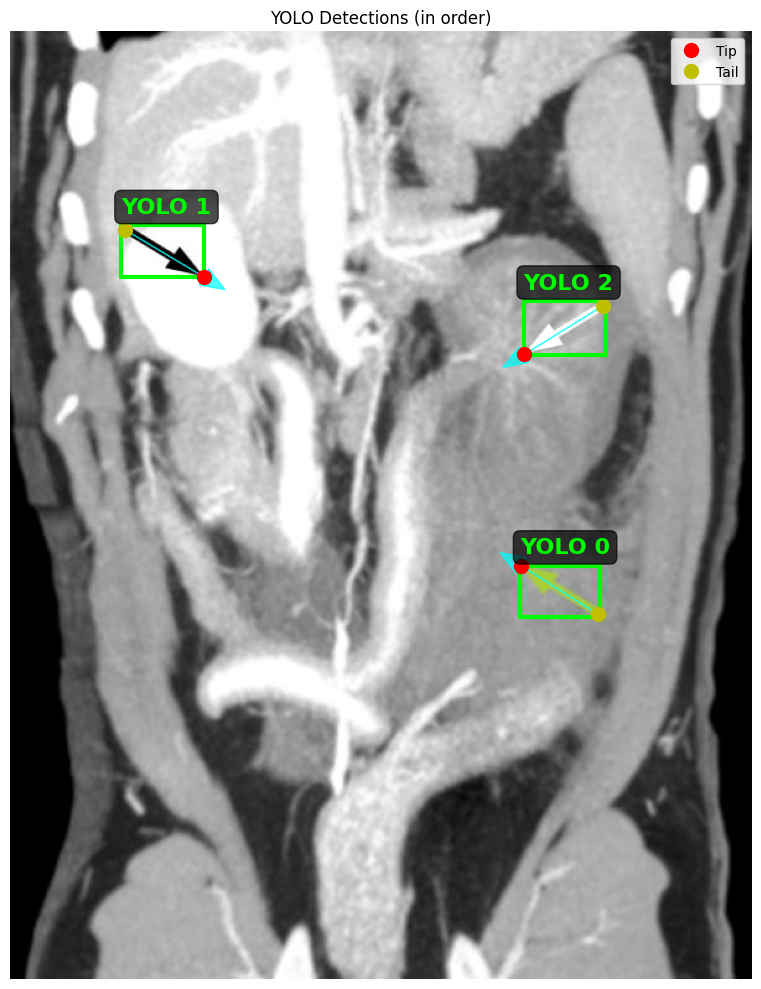

In [261]:
# Visualize YOLO detections in order with bounding boxes
result = results[0]
image_with_boxes = np.array(Image.open(image_path).convert("RGB"))

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.imshow(image_with_boxes)

if result.boxes is not None and len(result.boxes) > 0:
    for i, box in enumerate(result.boxes.xyxy):
        x1, y1, x2, y2 = box.cpu().numpy()

        # Draw bounding box
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                            fill=False, edgecolor='lime', linewidth=3)
        ax.add_patch(rect)

        # Add label with index
        ax.text(x1, y1-10, f'YOLO {i}',
               color='lime', fontsize=16, weight='bold',
               bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))

        # Draw keypoints if available
        if result.keypoints is not None and i < len(result.keypoints.xy):
            kpts = result.keypoints.xy[i].cpu().numpy()
            tip = kpts[0]
            tail = kpts[1]

            # Draw tip and tail
            ax.plot(tip[0], tip[1], 'ro', markersize=10, label='Tip' if i == 0 else '')
            ax.plot(tail[0], tail[1], 'yo', markersize=10, label='Tail' if i == 0 else '')

            # Draw arrow direction line
            ax.arrow(tail[0], tail[1], tip[0]-tail[0], tip[1]-tail[1],
                    head_width=15, head_length=20, fc='cyan', ec='cyan', alpha=0.7)

        print(f"YOLO Detection {i}: BBox = [{x1:.1f}, {y1:.1f}, {x2:.1f}, {y2:.1f}]")

ax.set_title('YOLO Detections (in order)')
ax.axis('off')
if result.keypoints is not None:
    ax.legend(loc='upper right')
plt.tight_layout()
plt.show()


### Use BBox to Help Prompt SAM

In [262]:
result = results[0]
input_boxes = [result.boxes.xyxy.tolist()]
print(f"Input Boxes for SAM: {input_boxes}")
input_labels = [[1 for _ in range(len(input_boxes[0]))]]
print(f"Positive Input Labels for SAM: {input_labels}")

Input Boxes for SAM: [[[411.77093505859375, 431.49298095703125, 476.4808044433594, 472.92877197265625], [89.601806640625, 156.3474578857422, 156.08169555664062, 198.4589080810547], [414.6557312011719, 217.3804473876953, 481.61676025390625, 260.8611145019531]]]
Positive Input Labels for SAM: [[1, 1, 1]]


In [9]:
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load SAM3 model
model = Sam3Model.from_pretrained("facebook/sam3")

# Use DataParallel to distribute across multiple GPUs if available
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs with DataParallel")
    model = torch.nn.DataParallel(model)

model = model.to(device)
processor = Sam3Processor.from_pretrained("facebook/sam3")

print(f"SAM3 model loaded on device(s): {device}")

Loading weights:   0%|          | 0/1468 [00:00<?, ?it/s]

Using 2 GPUs with DataParallel
SAM3 model loaded on device(s): cuda


In [263]:
def show_masks_on_black(image, masks):
    plt.figure(figsize=(18, 9))

    # Plot Input Image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Input Image")
    plt.axis("off")

    # Plot Output Image (Masks on Black)
    plt.subplot(1, 2, 2)

    # Ensure image is numpy array
    if hasattr(image, "size"):
        image_np = np.array(image)
    else:
        image_np = image

    h, w = image_np.shape[:2]

    # Create black background canvas
    final_canvas = np.zeros_like(image_np)

    n_detections = len(masks)
    plt.title(f"Output Image ({n_detections} masks)")
    plt.axis("off")

    if n_detections > 0:
        # Convert to numpy if tensor
        if isinstance(masks, torch.Tensor):
            masks_np = masks.cpu().numpy()
        else:
            masks_np = np.array(masks)

        # Combine all masks into a single boolean mask
        combined_mask = np.zeros((h, w), dtype=bool)

        for mask in masks_np:
            if mask.ndim == 3:
                mask = mask.squeeze()

            # Ensure boolean and combine
            mask_bool = mask > 0
            combined_mask = np.logical_or(combined_mask, mask_bool)

        # Apply the original image pixels where the mask is active
        final_canvas[combined_mask] = image_np[combined_mask]

    plt.imshow(final_canvas)
    plt.show()

In [204]:
def postprocess_mask(binary_mask, close_ks=3, open_ks=0, erode_iters=0, dilate_iters=0):
    """Post-process a binary mask for crisper edges using morphology."""
    if isinstance(binary_mask, torch.Tensor):
        mask_np = binary_mask.detach().cpu().numpy()
        device = binary_mask.device
    else:
        mask_np = np.array(binary_mask)
        device = "cpu"
    if mask_np.ndim == 3:
        mask_np = mask_np.squeeze()
    mask_u8 = (mask_np > 0).astype(np.uint8) * 255
    if close_ks > 0:
        kernel = np.ones((close_ks, close_ks), np.uint8)
        mask_u8 = cv2.morphologyEx(mask_u8, cv2.MORPH_CLOSE, kernel)
    if open_ks > 0:
        kernel = np.ones((open_ks, open_ks), np.uint8)
        mask_u8 = cv2.morphologyEx(mask_u8, cv2.MORPH_OPEN, kernel)
    if erode_iters > 0:
        mask_u8 = cv2.erode(mask_u8, np.ones((3, 3), np.uint8), iterations=erode_iters)
    if dilate_iters > 0:
        mask_u8 = cv2.dilate(mask_u8, np.ones((3, 3), np.uint8), iterations=dilate_iters)
    return torch.from_numpy(mask_u8 / 255.0).to(device)

Processed input size: torch.Size([1, 3, 1008, 1008])
Found 3 instances
Mask shape: torch.Size([766, 599])


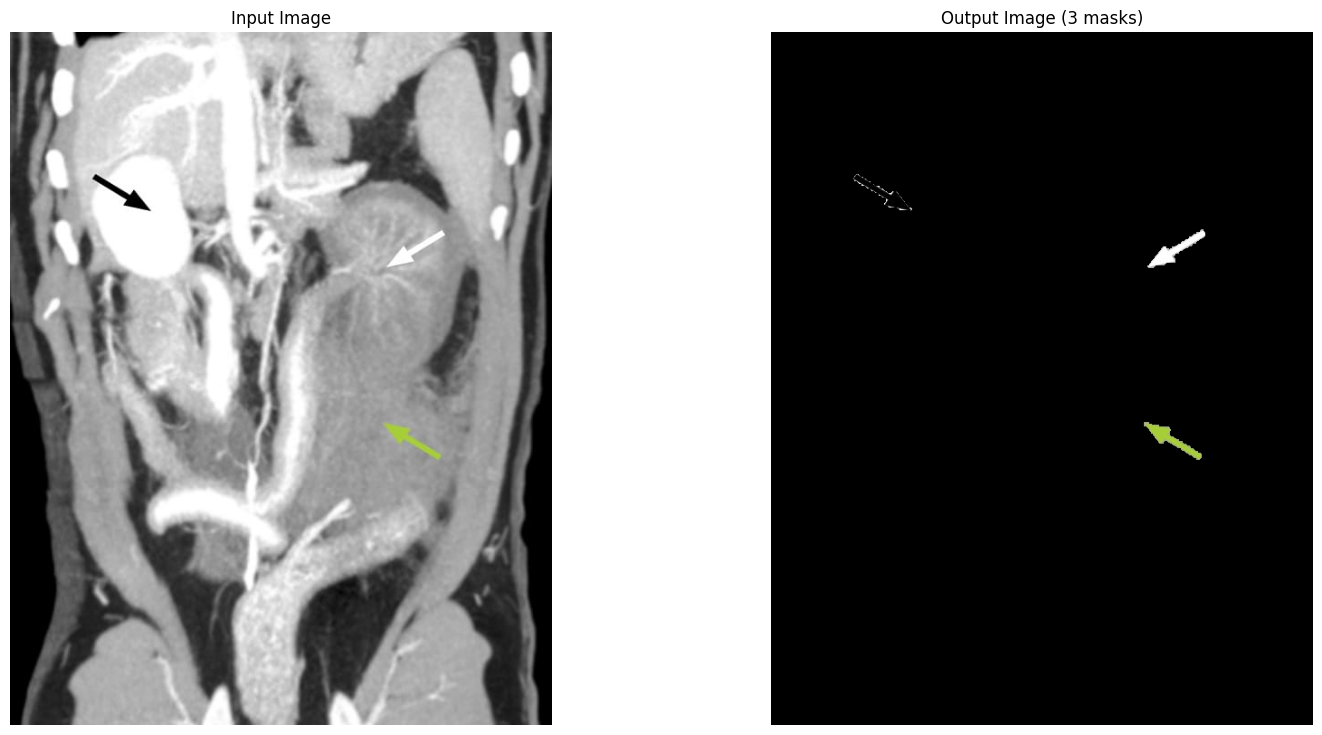

In [264]:
# Load an image
image = Image.open(image_path).convert("RGB")

#prompt = "arrows"

# Run segmentation with bbox prompt ONLY (no text prompt for better quality)
# Using only bbox prompts often produces higher quality masks than mixing text+bbox
inputs = processor(
    images=image,
    input_boxes=input_boxes,
    input_boxes_labels=input_labels,
    return_tensors="pt"
).to(device)

print(f"Processed input size: {inputs['pixel_values'].shape}")

with torch.no_grad():
  outputs = model(**inputs)

# Use lower thresholds to preserve more detail
# Lower threshold = more generous mask selection = better quality
output = processor.post_process_instance_segmentation(
    outputs,
    threshold=0.5,
    mask_threshold=0.5,
    target_sizes=inputs.get("original_sizes").tolist()
)[0]

# Results include masks, bounding boxes, and scores
masks, boxes, scores = output["masks"], output["boxes"], output["scores"]
print(f"Found {len(masks)} instances")
print(f"Mask shape: {masks[0].shape if len(masks) > 0 else 'N/A'}")

# Display the results

# Reduce speckle and tighten boundaries
masks = [postprocess_mask(m, close_ks=0, open_ks=0, erode_iters=0, dilate_iters=0) for m in masks]
masks = [m.cpu() for m in masks]

show_masks_on_black(image, masks)

SAM Mask 0: BBox = [411.6, 431.9, 477.0, 472.8]
SAM Mask 1: BBox = [90.0, 157.0, 155.6, 197.8]
SAM Mask 2: BBox = [415.8, 218.5, 480.8, 260.8]


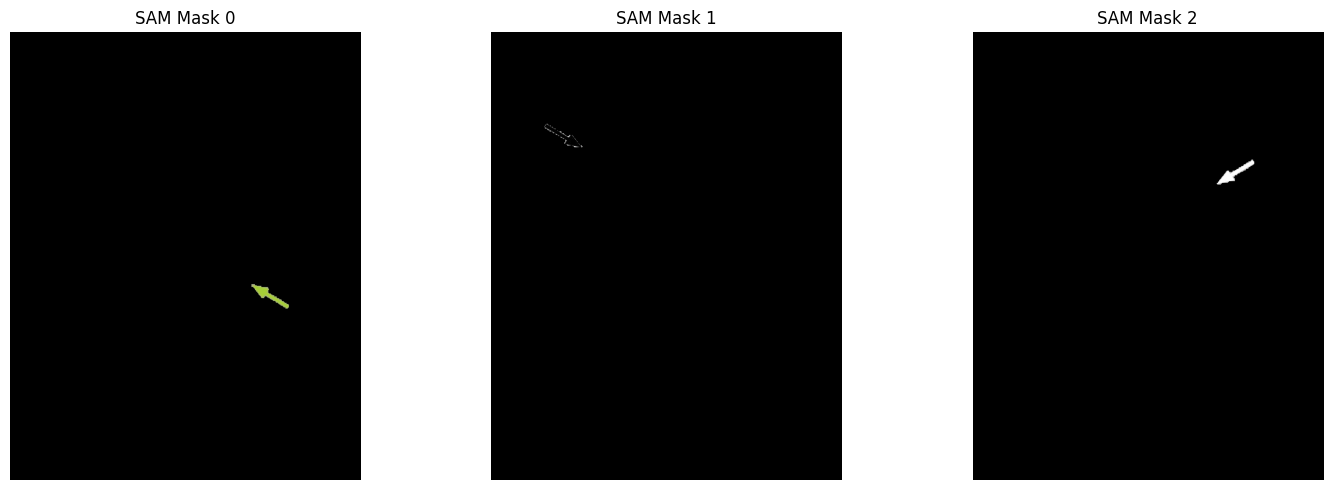

In [265]:
# Display each SAM mask individually using the same logic as show_masks_on_black
fig, axes = plt.subplots(1, len(masks), figsize=(5*len(masks), 5))
if len(masks) == 1:
    axes = [axes]

# Ensure image is numpy array
image_np = np.array(image) if hasattr(image, "size") else image
h, w = image_np.shape[:2]

for idx, (mask, box) in enumerate(zip(masks, boxes)):
    # Convert mask to numpy if needed
    if isinstance(mask, torch.Tensor):
        mask_np = mask.cpu().numpy()
    else:
        mask_np = np.array(mask)

    if mask_np.ndim == 3:
        mask_np = mask_np.squeeze()

    # Apply same thresholding as show_masks_on_black
    mask_bool = mask_np > 0

    # Render on black using original image pixels
    canvas = np.zeros_like(image_np)
    canvas[mask_bool] = image_np[mask_bool]

    axes[idx].imshow(canvas)
    axes[idx].set_title(f'SAM Mask {idx}')
    axes[idx].axis('off')

    # Print box coordinates
    if isinstance(box, torch.Tensor):
        box_coords = box.cpu().numpy()
    else:
        box_coords = box
    print(f"SAM Mask {idx}: BBox = [{box_coords[0]:.1f}, {box_coords[1]:.1f}, {box_coords[2]:.1f}, {box_coords[3]:.1f}]")

plt.tight_layout()
plt.show()


### Use YOLO Tip and Tail Points to Have Arrow Point To The Right

In [251]:
def rotate_arrow(image, tip, tail, target_angle=0, debug=False):
    """
    Rotate an arrow image so it points in the target direction.

    Parameters:
    -----------
    image : PIL.Image or np.ndarray
        RGBA image with the arrow
    tip : tuple
        (x, y) coordinates of arrow tip
    tail : tuple
        (x, y) coordinates of arrow tail
    target_angle : float
        Target angle in degrees (0 = right, 90 = up, 180 = left, -90 = down)
    debug : bool
        If True, print rotation details

    Returns:
    --------
    rotated_image : PIL.Image
        Rotated RGBA image
    """
    # Convert to PIL if needed
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)

    # Calculate current angle
    # dx and dy represent the vector from tail to tip
    dx = tip[0] - tail[0]
    dy = -(tip[1] - tail[1])  # Negate because y increases downward in image coords
    current_angle = math.degrees(math.atan2(dy, dx))

    # Calculate rotation needed to reach target angle
    # PIL rotates counter-clockwise, so negative angles rotate clockwise
    rotation_needed = target_angle - current_angle

    if debug:
        print(f"Tip: {tip}, Tail: {tail}")
        print(f"Current angle: {current_angle:.1f}°")
        print(f"Target angle: {target_angle:.1f}°")
        print(f"Rotation needed: {rotation_needed:.1f}° ({'counter-clockwise' if rotation_needed > 0 else 'clockwise'})")

    # Rotate image around its center with expansion to prevent cropping
    rotated = image.rotate(rotation_needed, resample=Image.BICUBIC, expand=True)

    return rotated


In [252]:
def match_sam_to_yolo(sam_boxes, yolo_boxes):
    """
    Match SAM output boxes to YOLO input boxes using IoU.
    Returns a list mapping SAM index to YOLO index.
    """
    def compute_iou(box1, box2):
        # box format: [x1, y1, x2, y2]
        x1 = max(box1[0], box2[0])
        y1 = max(box1[1], box2[1])
        x2 = min(box1[2], box2[2])
        y2 = min(box1[3], box2[3])

        intersection = max(0, x2 - x1) * max(0, y2 - y1)
        area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
        area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
        union = area1 + area2 - intersection

        return intersection / union if union > 0 else 0

    # Convert to numpy if needed
    if isinstance(sam_boxes, torch.Tensor):
        sam_boxes = sam_boxes.cpu().numpy()
    if isinstance(yolo_boxes, torch.Tensor):
        yolo_boxes = yolo_boxes.cpu().numpy()

    matches = []
    for sam_idx in range(len(sam_boxes)):
        best_iou = 0
        best_yolo_idx = 0

        for yolo_idx in range(len(yolo_boxes)):
            iou = compute_iou(sam_boxes[sam_idx], yolo_boxes[yolo_idx])
            if iou > best_iou:
                best_iou = iou
                best_yolo_idx = yolo_idx

        matches.append(best_yolo_idx)
        print(f"SAM Mask {sam_idx} → YOLO Detection {best_yolo_idx} (IoU: {best_iou:.4f})")

    return matches


In [255]:
def save_individual_masks(image, masks, sam_boxes, yolo_result, output_dir="arrow_masks", debug=False):
    """
    Save individual arrow masks as rotated RGBA PNGs pointing to the right.

    Parameters:
    -----------
    image : PIL.Image or np.ndarray
        Original image
    masks : list
        SAM segmentation masks
    sam_boxes : list
        Bounding boxes from SAM
    yolo_result : YOLO result object
        Contains keypoints (tip and tail) and bounding boxes for each arrow
    output_dir : str
        Directory to save the arrow PNGs
    debug : bool
        If True, print rotation details for each arrow

    Returns:
    --------
    saved_paths : list
        Paths to saved PNG files
    """
    output_dir = os.path.join("/gscratch/krishna/xckevin/arrow-detection/arrow-reapplication", output_dir)
    os.makedirs(output_dir, exist_ok=True)

    # Ensure image is numpy array
    if isinstance(image, Image.Image):
        image_np = np.array(image)
    else:
        image_np = image

    h, w = image_np.shape[:2]

    # Get keypoints from YOLO result
    if yolo_result.keypoints is None or len(yolo_result.keypoints.xy) == 0:
        print("Warning: No keypoints found in YOLO result. Cannot rotate arrows.")
        return []

    keypoints = yolo_result.keypoints.xy
    yolo_boxes = yolo_result.boxes.xyxy

    # Match SAM masks to YOLO detections
    print("\nMatching SAM masks to YOLO detections:")
    matches = match_sam_to_yolo(sam_boxes, yolo_boxes)
    print()

    saved_paths = []

    # Iterate through masks and boxes
    for sam_idx, (mask, box) in enumerate(zip(masks, sam_boxes)):
        yolo_idx = matches[sam_idx]

        if debug:
            print(f"\n--- Processing SAM Mask {sam_idx} (matched to YOLO {yolo_idx}) ---")

        # Convert mask to numpy if it's a tensor
        if isinstance(mask, torch.Tensor):
            mask = mask.cpu().numpy()
        
        # Create boolean mask (same thresholding as show_masks_on_black)
        mask_bool = mask > 0

        # Squeeze if needed (1, H, W) -> (H, W)
        if mask.ndim == 3:
            mask = mask.squeeze()

        # Create RGBA image (H, W, 4)
        rgba_image = np.zeros((h, w, 4), dtype=np.uint8)
        rgba_image[..., :3] = image_np  # RGB channels
        rgba_image[..., 3] = (mask_bool * 255).astype(np.uint8) # Alpha channel

        # Convert to PIL for cropping
        pil_image = Image.fromarray(rgba_image)

        # Crop using bounding box
        if isinstance(box, torch.Tensor):
            box = box.cpu().numpy()

        # Box is usually [x1, y1, x2, y2]
        x1, y1, x2, y2 = map(int, box)

        # Clamp coordinates to image boundaries
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w, x2), min(h, y2)

        # Crop
        cropped_arrow = pil_image.crop((x1, y1, x2, y2))

        # Get keypoints from matched YOLO detection
        kpts = keypoints[yolo_idx].tolist()
        tip_point = kpts[0]
        tail_point = kpts[1]

        if debug:
            print(f"  Using keypoints from YOLO detection {yolo_idx}")
            print(f"  Tip (global): {tip_point}, Tail (global): {tail_point}")

        # Adjust tip and tail points to be relative to cropped image
        tip_relative = (tip_point[0] - x1, tip_point[1] - y1)
        tail_relative = (tail_point[0] - x1, tail_point[1] - y1)

        # Rotate arrow to point right (0 degrees)
        cropped_arrow = rotate_arrow(cropped_arrow, tip_relative, tail_relative, target_angle=0, debug=debug)

        # Crop tightly around non-transparent pixels after rotation
        arrow_array = np.array(cropped_arrow)
        alpha_channel = arrow_array[:, :, 3]

        # Find bounding box of non-transparent pixels
        rows = np.any(alpha_channel > 0, axis=1)
        cols = np.any(alpha_channel > 0, axis=0)

        if np.any(rows) and np.any(cols):
            y_min, y_max = np.where(rows)[0][[0, -1]]
            x_min, x_max = np.where(cols)[0][[0, -1]]

            # Crop to tight bounding box
            cropped_arrow = cropped_arrow.crop((x_min, y_min, x_max + 1, y_max + 1))

            if debug:
                print(f"  Cropped to tight bounds: ({x_max + 1 - x_min}x{y_max + 1 - y_min})")

        # Resize to width of 540 pixels while preserving aspect ratio
        arrow_w, arrow_h = cropped_arrow.size
        if arrow_w > 0:
            new_h = int(540 * arrow_h / arrow_w)
            cropped_arrow = cropped_arrow.resize((540, new_h), Image.BICUBIC)
            if debug:
                print(f"  Resized to 540x{new_h}")

        # Save
        filename = f"arrow_{sam_idx+1}.png"
        save_path = os.path.join(output_dir, filename)
        cropped_arrow.save(save_path)
        saved_paths.append(save_path)
        print(f"Saved: {save_path}")

    return saved_paths



Matching SAM masks to YOLO detections:
SAM Mask 0 → YOLO Detection 0 (IoU: 0.9751)
SAM Mask 1 → YOLO Detection 1 (IoU: 0.9549)
SAM Mask 2 → YOLO Detection 2 (IoU: 0.9452)


--- Processing SAM Mask 0 (matched to YOLO 0) ---
  Using keypoints from YOLO detection 0
  Tip (global): [412.5053405761719, 431.38116455078125], Tail (global): [474.95556640625, 470.67779541015625]
Tip: (1.505340576171875, 0.38116455078125), Tail: (63.95556640625, 39.67779541015625)
Current angle: 147.8°
Target angle: 0.0°
Rotation needed: -147.8° (clockwise)
  Cropped to tight bounds: (75x24)
  Resized to 540x172
Saved: /gscratch/krishna/xckevin/arrow-detection/arrow-reapplication/arrow_masks/arrow_1.png

--- Processing SAM Mask 1 (matched to YOLO 1) ---
  Using keypoints from YOLO detection 1
  Tip (global): [156.3214111328125, 198.05615234375], Tail (global): [92.16645050048828, 159.7230682373047]
Tip: (66.3214111328125, 41.05615234375), Tail: (2.1664505004882812, 2.7230682373046875)
Current angle: -30.9°
Targ

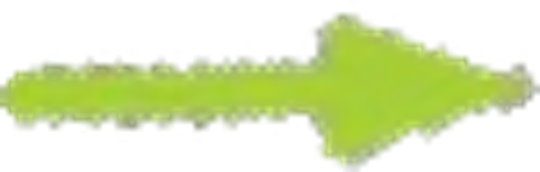

In [266]:
# Run the function using the variables from the previous cells
# Pass the YOLO result to get keypoints for rotation
# Set debug=True to see rotation details
saved_files = save_individual_masks(image, masks, boxes, result, debug=True)

# Display the first one as an example
if saved_files:
    print(f"\nDisplaying {saved_files[0]}:")
    display(Image.open(saved_files[0]))


### Place Derived Arrows Anywhere on Image

In [267]:
def resize_to_width(image_rgb, target_w=1024, interpolation=cv2.INTER_LINEAR):
    """
    Resize an RGB image to the specified width while preserving aspect ratio.

    Parameters:
    - image_rgb: np.ndarray (H,W,3) in RGB
    - target_w: int target width (default: 1024)
    - interpolation: OpenCV interpolation method

    Returns:
    - resized RGB image with width == target_w
    """
    h, w = image_rgb.shape[:2]
    if w == target_w:
        return image_rgb
    target_h = int(round(h * (target_w / w)))
    return cv2.resize(image_rgb, (target_w, target_h), interpolation=interpolation)

In [268]:
def preprocess_arrow(arrow_path, rotation_angle=0, scale=1.0):
    """
    Preprocess arrow PNG by rotating and resizing while preserving colors and aspect ratio.

    Parameters:
    -----------
    arrow_path : string
        Filepath of transparent background arrow image located in arrow-pngs folder
    rotation_angle : float
        Rotation angle in degrees (0 = pointing right, 90 = pointing up, -90 = pointing down, 180 = pointing left)
    scale : float, optional
        Uniform scale factor to resize arrow (default: 1.0, no resize)

    Returns:
    --------
    arrow_rgb : np.ndarray
        Rotated and scaled arrow image in RGB format
    alpha : np.ndarray
        Alpha channel for the rotated arrow
    tip_local : tuple
        (x, y) coordinates of the arrow tip in the rotated image
    tail_local : tuple
        (x, y) coordinates of the arrow tail in the rotated image
    bbox_local : tuple
        (x_min, y_min, x_max, y_max) of non-zero alpha in rotated image coords
    """
    arrow_image = cv2.imread(arrow_path, cv2.IMREAD_UNCHANGED)

    # Extract BGR and alpha from arrow image
    if arrow_image.shape[2] == 4:
        arrow_bgr = arrow_image[:, :, :3]
        alpha = arrow_image[:, :, 3] / 255.0
    else:
        arrow_bgr = arrow_image
        alpha = np.ones((arrow_image.shape[0], arrow_image.shape[1]))

    # Convert arrow from BGR to RGB
    arrow_rgb = cv2.cvtColor(arrow_bgr, cv2.COLOR_BGR2RGB)

    # Apply uniform scaling if needed
    if scale != 1.0:
        h, w = arrow_rgb.shape[:2]
        new_w = int(w * scale)
        new_h = int(h * scale)
        if new_w > 0 and new_h > 0:
            arrow_rgb = cv2.resize(arrow_rgb, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
            alpha = cv2.resize(alpha, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    # Original arrow dimensions and tip/tail positions (before rotation)
    # Tip is in the middle of the right side, tail on the left
    original_tip_local = (arrow_rgb.shape[1], arrow_rgb.shape[0] // 2)
    original_tail_local = (0, arrow_rgb.shape[0] // 2)

    # If no rotation needed, return as-is
    if rotation_angle == 0:
        # Compute bbox on current alpha
        ys, xs = np.nonzero(alpha > 0)
        if len(xs) == 0 or len(ys) == 0:
            bbox_local = (0, 0, 0, 0)
        else:
            bbox_local = (int(xs.min()), int(ys.min()), int(xs.max()), int(ys.max()))
        return arrow_rgb, alpha, original_tip_local, original_tail_local, bbox_local

    # Get the center of rotation (the tip point)
    h, w = arrow_rgb.shape[:2]
    center = original_tip_local

    # Create rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)

    # Calculate new canvas size to fit the rotated image
    # Get the four corners of the original image
    corners = np.array([
        [0, 0, 1],
        [w, 0, 1],
        [0, h, 1],
        [w, h, 1]
    ]).T

    # Transform corners to find new bounding box
    transformed = rotation_matrix @ corners
    x_coords = transformed[0, :]
    y_coords = transformed[1, :]

    x_min = int(np.floor(x_coords.min()))
    x_max = int(np.ceil(x_coords.max()))
    y_min = int(np.floor(y_coords.min()))
    y_max = int(np.ceil(y_coords.max()))

    new_w = x_max - x_min
    new_h = y_max - y_min

    # Adjust rotation matrix to account for the new canvas position
    rotation_matrix[0, 2] -= x_min
    rotation_matrix[1, 2] -= y_min

    # Rotate the arrow image with the expanded canvas
    arrow_rgb_rotated = cv2.warpAffine(arrow_rgb, rotation_matrix, (new_w, new_h),
                                        borderMode=cv2.BORDER_CONSTANT,
                                        borderValue=(0, 0, 0))

    # Rotate the alpha channel
    alpha_rotated = cv2.warpAffine(alpha, rotation_matrix, (new_w, new_h),
                                     borderMode=cv2.BORDER_CONSTANT,
                                     borderValue=0)

    # Transform the tail coordinates using the adjusted rotation matrix
    tail_point = np.array([original_tail_local[0], original_tail_local[1], 1]).reshape(3, 1)
    tail_rotated = rotation_matrix @ tail_point
    tail_local_rotated = (int(round(tail_rotated[0, 0])), int(round(tail_rotated[1, 0])))

    # Transform the tip coordinates
    tip_point = np.array([original_tip_local[0], original_tip_local[1], 1]).reshape(3, 1)
    tip_rotated = rotation_matrix @ tip_point
    tip_local_rotated = (int(round(tip_rotated[0, 0])), int(round(tip_rotated[1, 0])))

    # Compute tight bbox around non-zero alpha
    ys, xs = np.nonzero(alpha_rotated > 0)
    if len(xs) == 0 or len(ys) == 0:
        bbox_local = (0, 0, 0, 0)
    else:
        bbox_local = (int(xs.min()), int(ys.min()), int(xs.max()), int(ys.max()))

    return arrow_rgb_rotated, alpha_rotated, tip_local_rotated, tail_local_rotated, bbox_local


In [269]:
def overlay_random_arrows(base_image_rgb, arrow_dir, arrow_size=1, num_arrows=2, tip_margin_ratio=0.05):
    """
    Overlay multiple randomly preprocessed arrows onto a base RGB image.

    Returns:
    - output_rgb: np.ndarray (H,W,3) RGB image with arrows overlaid
    - tips: list of (x, y) tip locations on output image
    - tails: list of (x, y) tail locations on output image
    - bboxes: list of (x_min, y_min, x_max, y_max) for each overlaid arrow
    """
    base_h, base_w = base_image_rgb.shape[:2]
    margin_w = int(tip_margin_ratio * base_w)
    margin_h = int(tip_margin_ratio * base_h)

    # Collect arrow PNGs
    arrow_files = [f for f in os.listdir(arrow_dir) if f.lower().endswith(".png")]
    if not arrow_files:
        raise ValueError(f"No PNG files found in {arrow_dir}")

    def intersect_ranges(current, new_ranges):
        merged = []
        for a_start, a_end in current:
            for b_start, b_end in new_ranges:
                start = max(a_start, b_start)
                end = min(a_end, b_end)
                if start < end:
                    merged.append((start, end))
        return merged

    output = base_image_rgb.copy()
    tips = []
    tails = []
    bboxes = []

    for _ in range(num_arrows):
        # Random tip position within margins
        tip_x = random.randint(margin_w, max(margin_w, base_w - margin_w))
        tip_y = random.randint(margin_h, max(margin_h, base_h - margin_h))

        # Angular constraints so tail stays away from nearby edges
        allowed = [(0.0, 360.0)]
        right_edge = tip_x >= 0.8 * base_w
        left_edge = tip_x <= 0.2 * base_w
        top_edge = tip_y <= 0.2 * base_h
        bottom_edge = tip_y >= 0.8 * base_h
        if right_edge:
            allowed = intersect_ranges(allowed, [(0, 90), (270, 360)])
        if left_edge:
            allowed = intersect_ranges(allowed, [(90, 270)])
        if top_edge:
            allowed = intersect_ranges(allowed, [(0, 180)])
        if bottom_edge:
            allowed = intersect_ranges(allowed, [(180, 360)])
        if not allowed:
            allowed = [(0.0, 360.0)]

        spans = [b - a for a, b in allowed]
        total_span = sum(spans)
        pick = random.uniform(0, total_span)
        cumulative = 0.0
        rotation_angle = 0.0
        for (a, b), span in zip(allowed, spans):
            if pick <= cumulative + span:
                rotation_angle = random.uniform(a, b)
                break
            cumulative += span

        # Pick random arrow and preprocess with constrained rotation
        arrow_path = os.path.join(arrow_dir, random.choice(arrow_files))
        arrow_rgb, alpha, tip_local, tail_local, bbox_local = preprocess_arrow(arrow_path, rotation_angle, scale=float(arrow_size)/4)

        # Arrow dimensions
        arrow_h, arrow_w = arrow_rgb.shape[:2]

        # Compute tail position in output coordinates
        tail_x = tip_x + (tail_local[0] - tip_local[0])
        tail_y = tip_y + (tail_local[1] - tip_local[1])

        # Placement (top-left of arrow on output) so tip aligns
        arrow_x = tip_x - tip_local[0]
        arrow_y = tip_y - tip_local[1]

        # Overlap region
        y_start = max(0, arrow_y)
        y_end = min(base_h, arrow_y + arrow_h)
        x_start = max(0, arrow_x)
        x_end = min(base_w, arrow_x + arrow_w)

        # Corresponding region in arrow image
        arrow_y_start = y_start - arrow_y
        arrow_y_end = y_end - arrow_y
        arrow_x_start = x_start - arrow_x
        arrow_x_end = x_end - arrow_x

        # Blend
        if (y_end > y_start) and (x_end > x_start):
            alpha_region = alpha[arrow_y_start:arrow_y_end, arrow_x_start:arrow_x_end]
            for c in range(3):
                output[y_start:y_end, x_start:x_end, c] = (
                    output[y_start:y_end, x_start:x_end, c] * (1 - alpha_region) +
                    arrow_rgb[arrow_y_start:arrow_y_end, arrow_x_start:arrow_x_end, c] * alpha_region
                )

        # Compute bbox in output coordinates by shifting local bbox
        bx0, by0, bx1, by1 = bbox_local
        bbox_out = (
            arrow_x + bx0,
            arrow_y + by0,
            arrow_x + bx1,
            arrow_y + by1
        )

        tips.append((tip_x, tip_y))
        tails.append((tail_x, tail_y))
        bboxes.append(bbox_out)

    return output, tips, tails, bboxes

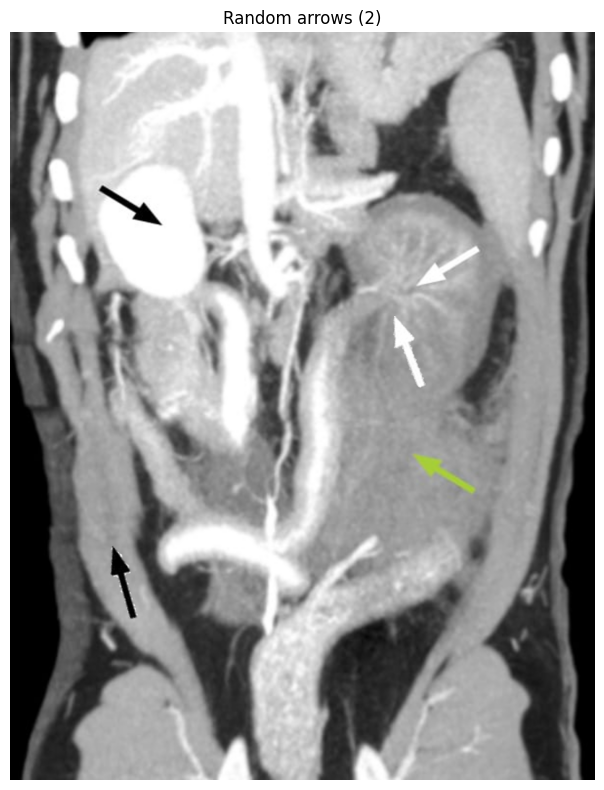

In [271]:
# Load base medical image
#base_image_path = os.path.join(project_path, "manual-tests/pic5.jpeg")
base_image = cv2.imread(image_path)
base_image_rgb = cv2.cvtColor(base_image, cv2.COLOR_BGR2RGB)

# Resize to width 1024 while preserving aspect ratio
base_image_rgb = resize_to_width(base_image_rgb, target_w=1024)

# Overlay multiple random arrows using the new helper function
arrow_dir = os.path.join("/gscratch/krishna/xckevin/arrow-detection/arrow-reapplication", "arrow_masks")
output_rgb, tips, tails, bboxes = overlay_random_arrows(base_image_rgb, arrow_dir, arrow_size=1, num_arrows=2)

# Display result
plt.figure(figsize=(10, 8))
plt.imshow(output_rgb)

plt.title(f"Random arrows ({len(bboxes)})")
plt.axis('off')
plt.tight_layout()
plt.show()